In [35]:
import numpy as np
from dask import delayed
from numba import jit
import nd2
import matplotlib.pyplot as plt
import pyfftw

# Local imports
from ddm.processing import radial_profile, radial_profile_jit

In [26]:
# Load dataset
def load_data(file: str = "../data/A1_s3001.nd2", num_frames: str = 500):
    data = nd2.imread(file, xarray=True, dask=False)
    data = data[:num_frames,:,:]
    return data.astype("complex64")

def load_data_delayed(file: str = "../data/A1_s3001.nd2", num_frames: str = 500):
    data = nd2.imread(file, xarray=True, dask=True)
    data = data[:num_frames,:,:]
    return data.astype("complex64")


In [87]:
# Helper functions
def get_diff_images(data, tau: int):
    """_summary_

    Parameters
    ----------
    data : _type_
        _description_
    tau : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    num_frames, height, width = data.shape
    image_fft_squared = np.zeros([width, height])
    for jj in range(num_frames - tau):
        image_diff = data[jj+tau] - data[jj]
        image_fft = np.fft.fft2(image_diff)
        image_fft_squared += np.abs(image_fft)**2
    
    fft_shift = np.fft.fftshift(image_fft_squared)
    return fft_shift

@jit(nopython=True, nogil=True)
def get_diff_images_jit(data: np.ndarray, tau: int):
    """_summary_

    Parameters
    ----------
    data : _type_
        _description_
    tau : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    num_frames, height, width = data.shape
    image_fft_squared = np.zeros([width, height])
    for jj in range(num_frames - tau):
        image_diff = data[jj+tau] - data[jj]
        image_fft = np.fft.fft2(image_diff)
        image_fft_squared += np.abs(image_fft)**2
    
    fft_shift = np.fft.fftshift(image_fft_squared)
    return fft_shift

def calc_correlation(image_fft_squared: np.ndarray, num_frames: int, tau: int):
    """_summary_

    Parameters
    ----------
    image_diff_squared : _type_
        _description_
    num_frames : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    height, width = image_fft_squared.shape
    fft_shift = np.fft.fftshift(image_fft_squared)
    gTau = fft_shift/(num_frames-tau)
    gTau_radial = radial_profile(gTau, (width/2., height/2.))
    return gTau_radial


In [66]:
def ddm_numpy(data, tau):
    """_summary_

    Parameters
    ----------
    data : _type_
        _description_
    tau : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    num_frames, height, width = data.shape

    gTau = np.zeros([width, height]) #initialise gTau to hold g(vec(q), tau) which will be radially averaged then saved
    imageDiffFTSquared = np.zeros([width, height]) #initialise zeros to hold the squared of the fourier transformed differences
    
    for jj in range(num_frames-tau): #j is the initial frame in the difference calculation, usually labelled as t
        imageDiff = data[jj+tau] - data[jj] #calculate the difference in pixel intensities between images
        imageDiffFT = np.fft.fft2(imageDiff) #fourier transform the difference
        imageDiffFTSquared += np.abs(imageDiffFT)**2 #for averaging this, add the square of the fourier transform to itself

    imageDiffFTSquared = np.fft.fftshift(imageDiffFTSquared)
    gTau = imageDiffFTSquared/(num_frames-tau)
    gTauRadial = radial_profile(gTau, (width/2., height/2.))
    return gTauRadial, imageDiffFTSquared    

def ddm_fftw(data, tau):
    """_summary_

    Parameters
    ----------
    data : _type_
        _description_
    tau : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    num_frames, height, width = data.shape

    pyfftw.interfaces.cache.enable()
    imageDiff = pyfftw.empty_aligned((height,width), dtype='complex64')
    fft_object = pyfftw.builders.fft2(imageDiff, threads = 8,overwrite_input=True, planner_effort = 'FFTW_ESTIMATE')

    gTau = np.zeros([width, height]) #initialise gTau to hold g(vec(q), tau) which will be radially averaged then saved
    imageDiffFTSquared = np.zeros([width, height]) #initialise zeros to hold the squared of the fourier transformed differences
    
    for jj in range(num_frames-tau): #j is the initial frame in the difference calculation, usually labelled as t
        imageDiff = data[jj+tau] - data[jj] #calculate the difference in pixel intensities between images        
        imageDiffFTSquared += np.abs(fft_object(imageDiff))**2 #for averaging this, add the square of the fourier transform to itself

    imageDiffFTSquared = np.fft.fftshift(imageDiffFTSquared)
    gTau = imageDiffFTSquared/(num_frames-tau)
    gTauRadial = radial_profile(gTau, (width/2., height/2.))
    return gTauRadial    

def ddm(data, tau: int):
    num_frames, _, _ = data.shape
    image_diff_squared = get_diff_images(data, tau)
    gTau_radial = calc_correlation(image_diff_squared, num_frames)
    return gTau_radial




## Benchmark without optimization

In [ ]:
data = load_data()

CPU times: total: 7.89 s
Wall time: 9.89 s


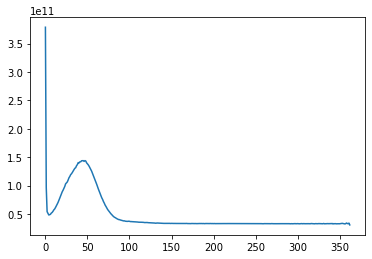

In [67]:
%%time
r1, image_diff_squared = ddm_numpy(data, 2)
plt.plot(r1);

CPU times: total: 5.77 s
Wall time: 5.13 s


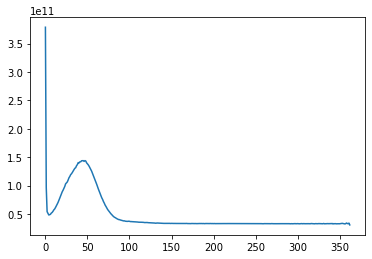

In [62]:
%%time
r2 = ddm_fftw(data, 2)
plt.plot(r2);

## Refactoring of functions

In [79]:
%%time
images_diff = get_diff_images(data, 1)

CPU times: total: 8.33 s
Wall time: 10.4 s


In [88]:
%%time
images_diff = get_diff_images_jit(data.to_numpy(), 1)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 2 candidate implementations:
[1m    - Of which 2 did not match due to:
    Overload of function 'zeros': File: numba\core\typing\npydecl.py: Line 511.
      With argument(s): '(list(int64)<iv=None>)':[0m
[1m     No match.[0m
[0m
[0m[1mDuring: resolving callee type: Function(<built-in function zeros>)[0m
[0m[1mDuring: typing of call at C:\Users\Maurits\AppData\Local\Temp\ipykernel_12964\551801932.py (44)
[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_12964\551801932.py", line 44:[0m
[1m<source missing, REPL/exec in use?>[0m


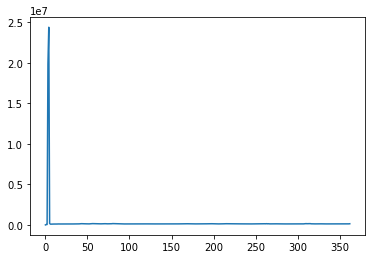

In [65]:
num_frames, height, width = data.shape
gtau = calc_correlation(images_diff, num_frames, 1)
plt.plot(gtau)

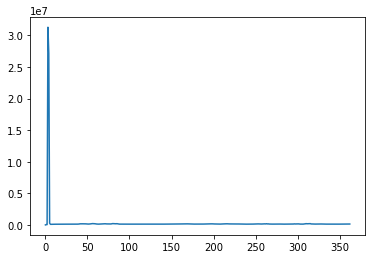

In [58]:
r3 = ddm(data, 2)
plt.plot(r3);